In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
import string

# IMDb: Summer I turned Pretty Reviews

## Version 1
- just 18 reviews

In [56]:
import requests
from bs4 import BeautifulSoup
import time
import random

def scrape_imdb_reviews(title_id):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.3",
    }
    base_url = f"https://www.imdb.com/title/{title_id}/reviews"
    session = requests.Session()
    # Step 1: Get the initial page
    response = session.get(base_url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    all_reviews = []
    all_titles = []
    # Step 2: Scrape the first page
    titles = soup.find_all("h3", class_="ipc-title__text")
    reviews = soup.find_all("div", class_="ipc-html-content-inner-div")
    pagination = soup.find("div", class_="pagination-container")
    print(pagination.prettify())


    all_titles.extend([title.get_text(strip=True) for title in titles])
    all_reviews.extend([review.get_text(strip=True) for review in reviews])
    return all_reviews


In [57]:
# Example usage
title_id = "tt14016500"  # The Summer I Turned Pretty
reviews = scrape_imdb_reviews(title_id)  # No max_pages limit anymore

print(f"Total reviews scraped: {len(reviews)}\n")
for idx, review in enumerate(reviews):
    print(f"Review {idx+1}: {review}\n")

<div class="sc-8ee20e1a-1 gwqZpp pagination-container">
 <span class="ipc-see-more sc-6d7bf963-0 eNJVyA single-page-see-more-button">
  <button aria-disabled="false" class="ipc-btn ipc-btn--single-padding ipc-btn--center-align-content ipc-btn--default-height ipc-btn--core-base ipc-btn--theme-base ipc-btn--button-radius ipc-btn--on-accent2 ipc-text-button ipc-see-more__button" tabindex="0">
   <span class="ipc-btn__text">
    <span class="ipc-see-more__text">
     25 more
    </span>
   </span>
   <svg class="ipc-icon ipc-icon--expand-more ipc-btn__icon ipc-btn__icon--post" fill="currentColor" height="24" role="presentation" viewbox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg">
    <path d="M24 24H0V0h24v24z" fill="none" opacity=".87">
    </path>
    <path d="M15.88 9.29L12 13.17 8.12 9.29a.996.996 0 1 0-1.41 1.41l4.59 4.59c.39.39 1.02.39 1.41 0l4.59-4.59a.996.996 0 0 0 0-1.41c-.39-.38-1.03-.39-1.42 0z">
    </path>
   </svg>
  </button>
 </span>
 <span class="ipc-see-more

In [43]:
import pandas as pd

# Save to CSV
df = pd.DataFrame(reviews, columns=["review"])
df.to_csv("../../data/imdb_reviews.csv", index=False)

In [45]:
len(reviews)

18

## Version 2

In [7]:
import requests
from bs4 import BeautifulSoup
import time
import random
import pandas as pd

def scrape_imdb_reviews(title_id, max_pages=300):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.3",
    }
    
    base_url = f"https://www.imdb.com/title/{title_id}/reviews"
    session = requests.Session()
    
    # Step 1: Start scraping reviews
    all_reviews = []
    all_titles = []
    current_page = 1
    
    while current_page <= max_pages:  # Limit the number of pages
        # Request the current page of reviews
        url = f"{base_url}?start={current_page * 25}" if current_page > 1 else base_url
        response = session.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # Step 2: Scrape the reviews from the page
        titles = soup.find_all("h3", class_="ipc-title__text")
        reviews = soup.find_all("div", class_="ipc-html-content-inner-div")
        
        # Ensure both titles and reviews lists are of the same length
        num_reviews = min(len(titles), len(reviews))
        
        # If both titles and reviews exist, append them
        if num_reviews > 0:
            all_titles.extend([title.get_text(strip=True) for title in titles[:num_reviews]])
            all_reviews.extend([review.get_text(strip=True) for review in reviews[:num_reviews]])

        # Step 3: Check for the pagination button to go to the next page
        next_button = soup.find("button", class_="ipc-see-more__button")
        if next_button and next_button.get_text(strip=True) == "25 more":
            current_page += 1
            # Sleep to mimic human behavior and avoid getting blocked
            time.sleep(random.uniform(1, 2))  # Reduced sleep time
        else:
            print("No more pages to scrape.")
            break  

    # Return reviews as a DataFrame
    df = pd.DataFrame({
        "Title": all_titles,
        "Review": all_reviews
    })
    
    return df

# Example usage
title_id = "tt14016500"  # Replace with your IMDb title ID
reviews_df = scrape_imdb_reviews(title_id)
print(f"Total reviews scraped: {len(reviews_df)}\n")
print(reviews_df.head())

Total reviews scraped: 5400

                                               Title  \
0         Frustrating...but I couldn't stop watching   
1           Sweet and fun but it's missing something   
2                                  What happened????   
3  Melded families spend yet another summer at th...   
4                          Second season disappoints   

                                              Review  
0  Amongst the cliches, irritating characters, an...  
1  This is more like a 6.5/10 for me. It was a sw...  
2  Season Two, 2023: It is July 2023 and the seco...  
3  I loved the first season of this show. It's a ...  
4  I feel like people get way to critical about t...  


In [8]:
reviews_df.to_csv('../../data/imdb_reviews.csv')

In [9]:
reviews_df.head(3)

,Title,Review
0,Frustrating...but I couldn't stop watching,"Amongst the cliches, irritating characters, an..."
1,Sweet and fun but it's missing something,This is more like a 6.5/10 for me. It was a sw...
2,What happened????,"Season Two, 2023: It is July 2023 and the seco..."


In [10]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|\#","", text)
    text = re.sub(r"[^\w\s]", '', text)
    text = text.lower().strip()
    return text

reviews_df['cleaned_review'] = reviews_df['Review'].apply(clean_text)
reviews_df['cleaned_title'] = reviews_df['Title'].apply(clean_text)
reviews_df

,Title,Review,cleaned_review,cleaned_title
0,Frustrating...but I couldn't stop watching,"Amongst the cliches, irritating characters, an...",amongst the cliches irritating characters and ...,frustratingbut i couldnt stop watching
1,Sweet and fun but it's missing something,This is more like a 6.5/10 for me. It was a sw...,this is more like a 6510 for me it was a sweet...,sweet and fun but its missing something
2,What happened????,"Season Two, 2023: It is July 2023 and the seco...",season two 2023 it is july 2023 and the second...,what happened
3,Melded families spend yet another summer at th...,I loved the first season of this show. It's a ...,i loved the first season of this show its a fu...,melded families spend yet another summer at th...
4,Second season disappoints,I feel like people get way to critical about t...,i feel like people get way to critical about t...,second season disappoints
...,...,...,...,...
5395,Are we suppose to like Belly?,This show was really amazing and special to me...,this show was really amazing and special to me...,are we suppose to like belly
5396,Should've ended with season one,It's 4am and I just finished binging this show...,its 4am and i just finished binging this show ...,shouldve ended with season one
5397,I don't really get the love triangle thing,Binge watched drama\n'The Summer I turned pret...,binge watched drama\nthe summer i turned prett...,i dont really get the love triangle thing
5398,Unexpected And Exactly What I Just Needed.,The perfect show to watch again and again in t...,the perfect show to watch again and again in t...,unexpected and exactly what i just needed


In [11]:
# Optional: Save cleaned data to a new CSV
reviews_df.to_csv("../../data/cleaned_reviews.csv", index=False)

# Topic Modeling

In [3]:
import nltk
reviews_df = pd.read_csv("../../data/cleaned_reviews.csv")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/matereyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matereyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/matereyes/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
# Preprocess the reviews (clean the text)
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]
    return tokens

# Apply preprocessing to each review
processed_reviews = [preprocess_text(review) for review in reviews_df['cleaned_review']]

# Create a dictionary and a corpus for LDA
dictionary = corpora.Dictionary(processed_reviews)
corpus = [dictionary.doc2bow(text) for text in processed_reviews]

print(f"Dictionary: {dictionary.token2id}")
print(f"Corpus: {corpus}")

Dictionary: {'amongst': 0, 'around': 1, 'casting': 2, 'characters': 3, 'choices': 4, 'cliches': 5, 'colorful': 6, 'comforting': 7, 'conrad': 8, 'costumes': 9, 'entertainingand': 10, 'excellent': 11, 'im': 12, 'irritating': 13, 'locations': 14, 'make': 15, 'otherwise': 16, 'performances': 17, 'quite': 18, 'series': 19, 'solid': 20, 'something': 21, 'soundtrack': 22, 'stunning': 23, 'team': 24, 'unoriginal': 25, 'way': 26, '6510': 27, 'already': 28, 'beachy': 29, 'binge': 30, 'chill': 31, 'easy': 32, 'feel': 33, 'felt': 34, 'fine': 35, 'fun': 36, 'interactions': 37, 'interesting': 38, 'like': 39, 'liked': 40, 'little': 41, 'made': 42, 'many': 43, 'pretty': 44, 'repetitive': 45, 'seen': 46, 'setting': 47, 'shallow': 48, 'stand': 49, 'stories': 50, 'story': 51, 'sweet': 52, 'thats': 53, 'times': 54, 'totally': 55, 'unnatural': 56, 'vibe': 57, 'watch': 58, 'well': 59, 'weve': 60, 'wished': 61, 'would': 62, '16': 63, '16yrolds': 64, '2022': 65, '2023': 66, '45': 67, '50': 68, '70s': 69, '7ep

In [14]:
from gensim.models import LdaModel

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.053*"season" + 0.026*"also" + 0.021*"want" + 0.021*"show" + 0.021*"get"')
(1, '0.018*"show" + 0.018*"good" + 0.018*"characters" + 0.018*"make" + 0.013*"watched"')
(2, '0.021*"season" + 0.019*"one" + 0.016*"series" + 0.011*"much" + 0.011*"god"')
(3, '0.027*"season" + 0.027*"material" + 0.027*"story" + 0.027*"binge" + 0.026*"like"')
(4, '0.032*"season" + 0.022*"story" + 0.019*"series" + 0.016*"good" + 0.016*"1"')


Topic 0 - Theme: Eagerness for more content or continuation of the story.
Topic 1: Character Evaluation / General Opinions [Theme: Viewer judgment of show quality and characters.]
Topic 2: Comparison / Emotional Reactions [Theme: Intense viewer emotions, maybe even frustration or amazement.]
Topic 3: Binge-Watching & Source Material
Topic 4: Season & Storyline Quality

# Word Cloud

In [4]:
# Install required libraries
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import pandas as pd
import string

# Preprocess text: lowercase, remove punctuation
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

reviews_df['processed'] = reviews_df['cleaned_review'].apply(preprocess)

# Simple sentiment function (positive if contains positive keywords, else negative)
positive_keywords = ["love", "amazing", "best", "dreamy", "cried", "emotional", "touching", "chemistry"]
negative_keywords = ["rushed", "terrible", "disappointed", "boring", "bad", "passive", "ruin"]

def get_sentiment(text):
    if any(word in text for word in positive_keywords):
        return "positive"
    elif any(word in text for word in negative_keywords):
        return "negative"
    return "neutral"

reviews_df["sentiment"] = reviews_df["processed"].apply(get_sentiment)

# Generate word clouds by sentiment
positive_text = " ".join(reviews_df[reviews_df["sentiment"] == "positive"]["processed"])
negative_text = " ".join(reviews_df[reviews_df["sentiment"] == "negative"]["processed"])

positive_wc = WordCloud(width=400, height=300, background_color='white').generate(positive_text)
negative_wc = WordCloud(width=400, height=300, background_color='black', colormap='Reds').generate(negative_text)

# TF-IDF + KMeans clustering
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews_df["processed"])
kmeans = KMeans(n_clusters=3, random_state=42)
reviews_df["cluster"] = kmeans.fit_predict(X)

# Return visuals and cluster assignment counts
(positive_wc, negative_wc, reviews_df[["cleaned_review", "cluster"]])


(<wordcloud.wordcloud.WordCloud at 0x1374e6c90>,
                                          cleaned_review  cluster
 0     amongst the cliches irritating characters and ...        2
 1     this is more like a 6510 for me it was a sweet...        2
 2     season two 2023 it is july 2023 and the second...        1
 3     i loved the first season of this show its a fu...        1
 4     i feel like people get way to critical about t...        1
 ...                                                 ...      ...
 5395  this show was really amazing and special to me...        1
 5396  its 4am and i just finished binging this show ...        2
 5397  binge watched drama\nthe summer i turned prett...        2
 5398  the perfect show to watch again and again in t...        1
 5399  first of all i have no idea why i watched it i...        2
 
 [5400 rows x 2 columns])

In [6]:
reviews_df.to_csv('../../data/cleaned_reviews.csv')

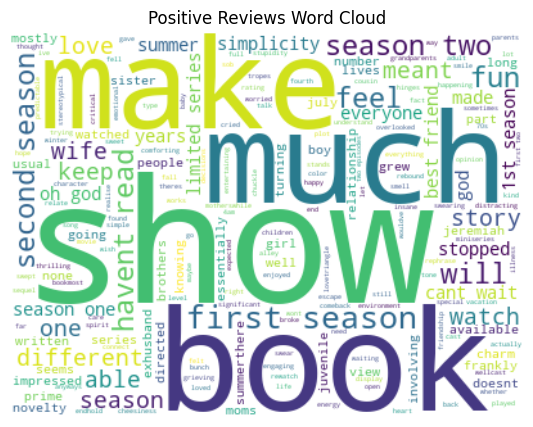

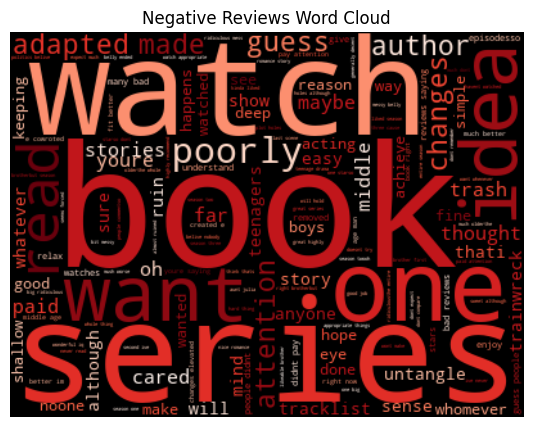

In [18]:
# Display the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

# Display the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()